# Outline

#### Stablish context and business objetive for the projet
    * define model outcome
    * define most relevant metrics
    * define how to select the "best model"
    * Define the general scoring function.   

#### Data Preprocessing according to the insights from the "Data Exploration" phase.
    * remove duplicate
    * remove inconsistencies
    * replace NaNs  
    * drop non-relevant features (optional)

#### Data Transformation: ready to train ML-models:
    * features-target separation
    * train-test split (unbalanced dataset)
    * data normalilzation
    * dataframe to array transformation

#### Stablish Null model  
    * Evaluate null model

#### Explore Base models: _logreg_, _svc_, _dt_, _knn_, ... _rf_. 
For each one:

    * Define the hyperparams of the model with GridSearch on the train_split (this will not be the final training)
    * Select the best hyper_params the model

#### Compare trained base models.  
    * Evaluate model metrics using the scoring function. Use the train_split. 


#### Train the best model.
    * select the "best model"
    * Train the model, from scratch, on the entire train_split at once (final base model training)
    * Use the entire dataset available (final training)

#### Final Model evaluation
    * Evaluate risk of overfitting by measuring the performance on the test_split (comparing with train_split performances).
    * optimize model with ROC-AUC (find best prob threshold)

#### Export trained model ready to wrap in API
    * Use joblib

# Context & Objectives

**Technical Objective:** Create a classifier to predict if a player will have career longer than 5 years.  

**Business Objective:** Determine if a player is a good opportunity of investment or not.  

* From the point of view of the investor it is important to identify as many good candidates as possible. This is translated into a model having a **_high recall_** for the positive class. A low recall model will limit the "growth capacity" of the investors.

* But it is also important for the investor to avoid "bad investments" (believing a player's career will be longer than 5 years, when it is not). This is translated into a model that besides having high recall, must have a high precision. A low precision model will result in investments made on the wrong players, which can not only limit the growth capacity of the investor but can also result important capital losses.  


**Criteria for "best model":**
* For finding a model with high recall and high precision, the f1-score is a good metric.
* The area under the curve roc-auc is also a good metric to find a model that properly balances recall and precision, and that it can be tuned.

## Scoring Function

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve, auc


In [2]:
def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return: the confusion matrix and the recall, precision, f1 and auc score estimations.
    """

    kf = StratifiedKFold(n_splits=3,random_state=50,shuffle=True)    
    confusion_mat = np.zeros((2,2))
    recall, precision, f1 = 0, 0, 0
    auc_score = 0

    for training_ids,test_ids in kf.split(dataset,labels):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]

        test_set = dataset[test_ids]
        test_labels = labels[test_ids]

        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        proba_pred = classifier.predict_proba(test_set)
        
        confusion_mat+=confusion_matrix(test_labels,predicted_labels, labels=[0,1])
        recall += recall_score(test_labels, predicted_labels, average='binary')
        precision += precision_score(test_labels, predicted_labels, average='binary')
        f1 += f1_score(test_labels, predicted_labels, average='binary')

        fpr, tpr, thresholds = roc_curve(test_labels, proba_pred[:,1], pos_label = 1)
        auc_score += auc(fpr, tpr)

    
    recall/=3
    precision/=3
    f1/=3
    auc_score/=3

    print(f"recall: \t{recall: .6f}")
    print(f"precision: \t{precision: .6f}")
    print(f"f1 score: \t{f1: .6f}")
    print(f"auc score: \t{auc_score: .5f}")
    print("confusion matrix:\n",confusion_mat, '\n')

# Data Preprocessing

In [3]:
## import raw data
df = pd.read_csv(".\\data.csv")
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


#### Clean dataset

In [4]:
## Remove simple duplicates
df.drop_duplicates(inplace = True)

## Remove inconsistent observations
inconsistents = df.drop('TARGET_5Yrs', axis = 1).duplicated()
df.drop(df.loc[inconsistents,:].index, axis=0, inplace=True)

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
df.fillna(0.0, inplace=True)

In [5]:
# apply the log transformation
exclude_columns = ['Name','GP','FT%','TARGET_5Yrs']
columns_to_transform = df.columns.difference(exclude_columns)
columns_to_transform

df[columns_to_transform] = df[columns_to_transform].apply(np.log1p)
df.head()


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,3.346389,2.128232,1.280934,2.151762,3.575151,0.405465,1.131402,3.258097,...,1.193922,69.9,0.530628,1.481605,1.629241,1.064711,0.336472,0.336472,0.832909,0.0
1,Andrew Harrison,35,3.328627,2.104134,1.098612,2.041220,3.421000,0.530628,1.335001,3.198673,...,1.481605,76.5,0.405465,1.098612,1.223775,1.547563,0.741937,0.405465,0.955511,0.0
2,JaKarr Sampson,74,2.791165,1.824549,1.098612,1.740466,3.765840,0.336472,0.993252,3.234749,...,0.832909,67.0,0.405465,0.993252,1.163151,0.693147,0.405465,0.262364,0.693147,0.0
3,Malik Sealy,58,2.533697,1.902108,1.193922,1.871802,3.775057,0.095310,0.405465,3.161247,...,0.832909,68.9,0.693147,0.641854,1.064711,0.587787,0.470004,0.095310,0.693147,1.0
4,Matt Geiger,48,2.525729,1.704748,0.955511,1.386294,3.977811,0.000000,0.095310,0.000000,...,1.064711,67.4,0.693147,0.916291,1.252763,0.262364,0.262364,0.336472,0.587787,1.0


#### Drop non relevant features (Optional)
Chose the list of features to drop

In [6]:
# irrelevant_features = ['FGA', '3PA', 'FTA', 'REB', 'FT%', '3P Made', '3PA']  ## from the correlation matrix insgihts
irrelevant_features = ['3P Made', '3PA']  ## from the statistical tests insights
# irrelevant_features = []   ## keep all features

df.drop(irrelevant_features, axis=1, inplace=True)

df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,3.346389,2.128232,1.280934,2.151762,3.575151,3.258097,0.955511,1.193922,69.9,0.530628,1.481605,1.629241,1.064711,0.336472,0.336472,0.832909,0.0
1,Andrew Harrison,35,3.328627,2.104134,1.098612,2.041220,3.421000,3.198673,1.280934,1.481605,76.5,0.405465,1.098612,1.223775,1.547563,0.741937,0.405465,0.955511,0.0
2,JaKarr Sampson,74,2.791165,1.824549,1.098612,1.740466,3.765840,3.234749,0.641854,0.832909,67.0,0.405465,0.993252,1.163151,0.693147,0.405465,0.262364,0.693147,0.0
3,Malik Sealy,58,2.533697,1.902108,1.193922,1.871802,3.775057,3.161247,0.641854,0.832909,68.9,0.693147,0.641854,1.064711,0.587787,0.470004,0.095310,0.693147,1.0
4,Matt Geiger,48,2.525729,1.704748,0.955511,1.386294,3.977811,0.000000,0.832909,1.064711,67.4,0.693147,0.916291,1.252763,0.262364,0.262364,0.336472,0.587787,1.0


In [7]:
df.shape

(1308, 19)

# Data transformation

#### Separate features & target

In [8]:
features = df.drop(['TARGET_5Yrs'], axis=1)
target = df['TARGET_5Yrs']

print(type(features))
print(type(target))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split Train & Test dataset

In [9]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=123)


In [10]:
## verify that proportion of class 1 in the split is more or less 62%, as seen in the data exploration phase
y_train.value_counts(normalize=True)

TARGET_5Yrs
1.0    0.620459
0.0    0.379541
Name: proportion, dtype: float64

#### data formating: dataframes -> arrays 
* get feature names, feature values, target labels, players names, etc

In [11]:
# feature names (same for train and test datasets)
paramset = data_train.drop(['Name'],axis=1).columns.values

# extract player names, target values (labels) and train values
names_train = data_train['Name'].values.tolist()
labels_train = y_train.values
X_train_vals = data_train.drop(['Name'],axis=1).values

In [12]:
## Same for test dataset

# extract player names, target values (labels) and train values
names_test = data_test['Name'].values.tolist()
labels_test = y_test.values
X_test_vals = data_test.drop(['Name'],axis=1).values

#### Normalize datasets
* Scale data to [0-1] range

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit scaler with the training set
X_train = scaler.fit_transform(X_train_vals)

# tranform the test data with the same scaler
X_test = scaler.transform(X_test_vals)

# Null Model

The Null model will predict always the moss common class seen on the training dataset.

In [14]:
## visualize most common class
y_train.value_counts()

TARGET_5Yrs
1.0    649
0.0    397
Name: count, dtype: int64

In [15]:
## define null model object
class null_model:
    def __init__(self):
        self.prediction = None
        self.probability = None

    def fit(self, X_train, y_train):
        dominant_class = pd.Series(y_train).value_counts().idxmax()
        dominant_class_rate = pd.Series(y_train).value_counts(normalize=True).max()
        self.prediction = dominant_class
        self.probability = dominant_class_rate


    def predict(self, X_test):
        num_obs = len(X_test)
        return np.array([self.prediction for _ in range(num_obs)])

    
    def predict_proba(self, X_test):
        num_obs = len(X_test)
        return np.array([[1-self.probability, self.probability] for _ in range(num_obs)])


In [16]:
## Instantiate model, train it 
clf_null = null_model()
clf_null.fit(X_train, y_train)


## make new predictions
labels_pred = clf_null.predict(X_test)

**Null model scoring on _train set_:**

In [17]:
## Scoring function on train set

print(f"===== Null model =====")
score_classifier(X_train, clf_null, labels_train)
print("\n")

===== Null model =====
recall: 	 1.000000
precision: 	 0.620459
f1 score: 	 0.765781
auc score: 	 0.50000
confusion matrix:
 [[  0. 397.]
 [  0. 649.]] 





**Null model evaluation on _test set_:**

In [18]:
## Evaluate performance on test set
cm = pd.crosstab(labels_test, labels_pred, rownames = ['Reality'], colnames = ['Prediction'])
display(cm)


## detailed report
from sklearn.metrics import classification_report
cr = classification_report(labels_test, labels_pred)
print(cr)


Prediction,1.0
Reality,
0.0,95
1.0,167


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        95
         1.0       0.64      1.00      0.78       167

    accuracy                           0.64       262
   macro avg       0.32      0.50      0.39       262
weighted avg       0.41      0.64      0.50       262



C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Base models

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

### Logistic regression

In [20]:
## instantiate model
clf = LogisticRegression()  

## grid search pre-optimization
params = {'C' : [0.9,1,2,3,4,5,7,8,10]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_lr = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

       params  mean_test_accuracy  mean_test_f1  mean_test_recall
0  {'C': 0.9}            0.709355      0.779047          0.825927
1    {'C': 1}            0.710312      0.779583          0.825939
2    {'C': 2}            0.712235      0.781587          0.830566
3    {'C': 3}            0.714149      0.783388          0.833643
4    {'C': 4}            0.713192      0.781780          0.829040
5    {'C': 5}            0.716058      0.783798          0.830578
6    {'C': 7}            0.715111      0.781954          0.824425
7    {'C': 8}            0.711287      0.779358          0.822886
8   {'C': 10}            0.714154      0.782025          0.827501 

Best params: {'C': 5}


### Support Vector Machine

In [21]:
## instantiate model
clf = SVC(probability = True)  

## grid search pre-optimization
params = {'C' : [0.1,1,10],
          'kernel' : ['rbf'],
          'gamma'  : [0.01, 0.1, 0.5, 1.0, 2.0]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_svc = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                                        params  mean_test_accuracy  \
0   {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}            0.620460   
1    {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}            0.624283   
2    {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}            0.706494   
3    {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}            0.706494   
4    {'C': 0.1, 'gamma': 2.0, 'kernel': 'rbf'}            0.689273   
5     {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}            0.627154   
6      {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}            0.712231   
7      {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}            0.711278   
8      {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}            0.717024   
9      {'C': 1, 'gamma': 2.0, 'kernel': 'rbf'}            0.709383   
10   {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}            0.711292   
11    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}            0.716058   
12    {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}            0.712231   
13    {'C': 10, 'gam

In [22]:
score_classifier(X_train, clf, labels_train)

recall: 	 0.788993
precision: 	 0.742684
f1 score: 	 0.764308
auc score: 	 0.73796
confusion matrix:
 [[219. 178.]
 [137. 512.]] 



### K-Neighbors

In [23]:
## instantiate model
clf = KNeighborsClassifier()  

## grid search pre-optimization
params = {'n_neighbors' : [3,5,10,12,15,17,20,24]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_knn = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                params  mean_test_accuracy  mean_test_f1  mean_test_recall
0   {'n_neighbors': 3}            0.657708      0.732985          0.757984
1   {'n_neighbors': 5}            0.663486      0.736987          0.761205
2  {'n_neighbors': 10}            0.679754      0.737597          0.727299
3  {'n_neighbors': 12}            0.680688      0.740864          0.736506
4  {'n_neighbors': 15}            0.683568      0.751578          0.771998
5  {'n_neighbors': 17}            0.690267      0.757686          0.781228
6  {'n_neighbors': 20}            0.693137      0.752800          0.755003
7  {'n_neighbors': 24}            0.692194      0.752026          0.753488 

Best params: {'n_neighbors': 17}


### Random Forest

In [24]:
## instantiate model
clf = RandomForestClassifier(n_jobs=-1, random_state=321)  

## grid search pre-optimization
params = {'max_depth' : [10,25,50,70],
          'n_estimators' : [100,250,500]} #

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_rf = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                                    params  mean_test_accuracy  mean_test_f1  \
0   {'max_depth': 10, 'n_estimators': 100}            0.713201      0.777929   
1   {'max_depth': 10, 'n_estimators': 250}            0.707464      0.773605   
2   {'max_depth': 10, 'n_estimators': 500}            0.717006      0.780455   
3   {'max_depth': 25, 'n_estimators': 100}            0.696947      0.765370   
4   {'max_depth': 25, 'n_estimators': 250}            0.707469      0.775298   
5   {'max_depth': 25, 'n_estimators': 500}            0.710317      0.778267   
6   {'max_depth': 50, 'n_estimators': 100}            0.696947      0.765370   
7   {'max_depth': 50, 'n_estimators': 250}            0.707469      0.775298   
8   {'max_depth': 50, 'n_estimators': 500}            0.710317      0.778267   
9   {'max_depth': 70, 'n_estimators': 100}            0.696947      0.765370   
10  {'max_depth': 70, 'n_estimators': 250}            0.707469      0.775298   
11  {'max_depth': 70, 'n_estimators': 50

## Gradient Boosting
Try a more advanced model to compare with the base models

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=0)

## grid search pre-optimization
params = {'n_estimators' : [10,20,50,100], 
          'learning_rate' : [0.1, 1],
          'max_depth' : [1,5,10]} #

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_gb = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                                               params  mean_test_accuracy  \
0   {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...            0.666334   
1   {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...            0.697863   
2   {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...            0.711255   
3   {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...            0.705491   
4   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...            0.698811   
5   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...            0.714131   
6   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...            0.697845   
7   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...            0.694026   
8   {'learning_rate': 0.1, 'max_depth': 10, 'n_est...            0.653889   
9   {'learning_rate': 0.1, 'max_depth': 10, 'n_est...            0.673976   
10  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...            0.683563   
11  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...            0.707473   

# Compared pre-selected Base models

In [26]:
models = [('Null model', clf_null),
          ('logistic regression', clf_lr),
          ('support vectors', clf_svc), 
          ('k-neighbors', clf_knn),
          ('random forest', clf_rf),
          ('gradient boost', clf_gb)]

for model_name, clf in models:
    print(f"===== {model_name} =====")
    score_classifier(X_train, clf, labels_train)
    # print("\n")

===== Null model =====
recall: 	 1.000000
precision: 	 0.620459
f1 score: 	 0.765781
auc score: 	 0.50000
confusion matrix:
 [[  0. 397.]
 [  0. 649.]] 

===== logistic regression =====
recall: 	 0.828960
precision: 	 0.744361
f1 score: 	 0.784320
auc score: 	 0.76812
confusion matrix:
 [[212. 185.]
 [111. 538.]] 

===== support vectors =====
recall: 	 0.819764
precision: 	 0.738657
f1 score: 	 0.776682
auc score: 	 0.76065
confusion matrix:
 [[208. 189.]
 [117. 532.]] 

===== k-neighbors =====
recall: 	 0.795137
precision: 	 0.733438
f1 score: 	 0.762376
auc score: 	 0.72712
confusion matrix:
 [[209. 188.]
 [133. 516.]] 

===== random forest =====
recall: 	 0.785871
precision: 	 0.734103
f1 score: 	 0.758650
auc score: 	 0.74910
confusion matrix:
 [[211. 186.]
 [139. 510.]] 

===== gradient boost =====
recall: 	 0.822822
precision: 	 0.725200
f1 score: 	 0.770746
auc score: 	 0.74001
confusion matrix:
 [[194. 203.]
 [115. 534.]] 



# Select best model

* The **logistic regression** model trained with al the features has the best auc score.
* The **Support vectors machine** model trained with all features has a higher precision, at the cost of some recall.
* The **Support vectors machine** model trained without features '3P Made' and '3PA' has balanced metrics.


In [27]:
best_model = clf_svc

In [28]:
## instantiate new model
best_params = best_model.get_params()

best_params['probability'] = True
clf_best = SVC(**best_params)

# clf_best = LogisticRegression(**best_params)
# clf_best = GradientBoostingClassifier(**best_params)


In [29]:
## Re-train the best model on the entire training dataset
clf_best.fit(X_train, labels_train)

## make prediction
labels_pred = clf_best.predict(X_test)
proba_pred = clf_best.predict_proba(X_test)

# Best model Evaluation

In [30]:
## check for overfitting risk

train_acc = clf_best.score(X_train, labels_train) 
test_acc = clf_best.score(X_test, labels_test)

print(f"Accuracy on train dataset = {train_acc: .4f}")
print(f"Accuracy on test dataset = {test_acc: .4f}")

Accuracy on train dataset =  0.7275
Accuracy on test dataset =  0.7557


In [31]:
## Evaluate performance on test set

cm = pd.crosstab(labels_test, labels_pred, rownames = ['Reality'], colnames = ['Prediction'])
display(cm)


## detailed report
from sklearn.metrics import classification_report
cr = classification_report(labels_test, labels_pred)
print(cr)

Prediction,0.0,1.0
Reality,,
0.0,53,42
1.0,22,145


              precision    recall  f1-score   support

         0.0       0.71      0.56      0.62        95
         1.0       0.78      0.87      0.82       167

    accuracy                           0.76       262
   macro avg       0.74      0.71      0.72       262
weighted avg       0.75      0.76      0.75       262



## Further model optimization

Optimal probability threshold =  0.6403
	 true positive rate =  0.7725
	 false positive rate =  0.3158


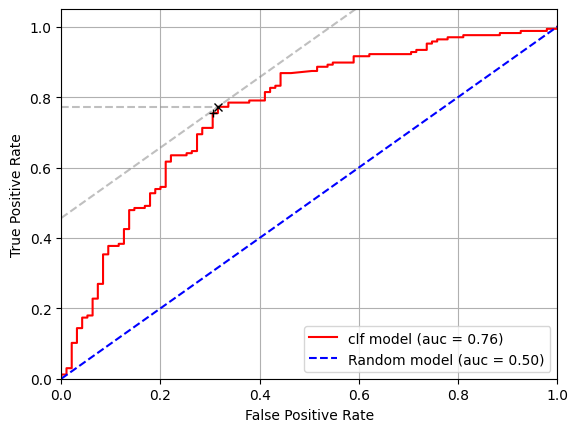

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels_test, proba_pred[:,1], pos_label = 1)
auc = auc(fpr, tpr)

# Optimal point is the touching point closer to the (1,0) corner. 
idx = (tpr-fpr).argmax() 
print(f"Optimal probability threshold = {thresholds[idx]: .4f}")
print(f"\t true positive rate = {tpr[idx]: .4f}")
print(f"\t false positive rate = {fpr[idx]: .4f}")

# models:
plt.plot(fpr, tpr, c = 'r', label = 'clf model (auc = %0.2f)' % auc)
plt.plot(fpr, fpr, c = 'b', label = 'Random model (auc = 0.50)', ls ='--')

# indicators: 
dy = tpr[idx]-fpr[idx]
plt.plot(fpr, fpr+dy, c = 'gray', alpha=0.5, ls ='--')
plt.axhline(y=tpr[idx], xmin=0, xmax=fpr[idx], color='gray', alpha=0.5, ls ='--')
plt.plot(fpr[idx], tpr[idx], c = 'k', marker = 'x')
plt.plot(fpr[50], tpr[50], c = 'k', marker = '+')

# formating:
plt.grid(visible=True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([0,1,0,1.05])
plt.legend()
plt.show()

**Notes:**

* The model can be improved a bit by changing the probability threshold.
* on the API use the model to predict probabilities and use the tunned threshold.
* the threshodl can be a risk parameter led to an investor to set as input.
* optimal model catches 77% of the good player, with a risk of 35% of investing in a bad player.

# Export trained Model

In [197]:
from joblib import dump, load

model_name = 'test'

# fitted data scaler
dump(scaler, './models/scaler_for_' + model_name +'_model.joblib')

# trained model
dump(clf_best, './models/'+ model_name +'_model.joblib')

# Save model performenace in test set
rocauc_dict = {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds}
model_rocauc = pd.DataFrame(rocauc_dict)
model_rocauc.to_csv('./models/'+ model_name +'_model_rocauc.csv', index=False)